# Steerable Pyramid Demo


In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch import nn
import matplotlib.pyplot as plt

import pyrtools as pt
import plenoptic as po
from plenoptic.tools.signal import rcosFn, pointOp
%matplotlib inline

from plenoptic.simulate import Steerable_Pyramid_Freq
from plenoptic.synthesize import Eigendistortion
from plenoptic.tools.display import convert_pyrshow

dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload

%autoreload 2

ModuleNotFoundError: No module named 'pyrtools'

Steerable Pyramids decompose an image into several bands with each corresponding to a particular orientation and spatial scale. This can be thought of as (invertible) feature extraction using the filters visualized below. For more details on steerable pyramids in general and how they are built, see the pyrtools tutorial at: https://pyrtools.readthedocs.io/en/latest/. Additionally for more about the specifics of the plenoptic pytorch implementation of the steerable pyramid and its basic features see https://github.com/LabForComputationalVision/plenoptic/blob/master/examples/03_Steerable_Pyramid.ipynb.

This demo will walk through an example use of a steerable pyramid as a front end for a convolutional network trained on a classification task, and then probe how the use of the pyramid can effect the learned representation. 

In [ ]:
order = 3
imsize = 64
pyr = Steerable_Pyramid_Freq(height=3,image_shape=[imsize,imsize],order=order,is_complex = False,twidth=1, downsample=False)
pyr.to(device)
empty_image = torch.zeros((1,1,imsize,imsize),dtype=dtype).to(device)
pyr_coeffs = pyr.forward(empty_image)

for k,v in pyr.pyr_size.items():
    mid = (v[0]//2, v[1]//2)
    pyr_coeffs[k][0,0,mid[0],mid[1]]=1

reconList = []
for k in pyr_coeffs.keys():
    if isinstance(k, tuple):
        reconList.append(pyr.recon_pyr(pyr_coeffs, k[0], k[1]).real)
    else:
        reconList.append(pyr.recon_pyr(pyr_coeffs, k).real)
        
po.imshow(reconList, col_wrap=order+1, vrange='indep1', zoom=1);

\* Note: The plenoptic implementation of steerable pyramid is defined in the frequency domain, not the spatial domain. This is why to visualize the filters we invert (map from pyramid domain back to image domain) an impulse placed in each band.

## Using the Steerable Pyramid as a fixed front end for a classification task

While similar decompositions often are learned in the early stages of deepnets trained on computer vision tasks, using a steerable pyramid as a front end offers more theoretical guarantees and can reduce the number of learned parameters required for a given task. Below we train two models on the FashionMNIST dataset, one with and one without a steerable pyramid front end.

In [2]:
# First we define/download the dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

In [3]:
# Define a simple model: SteerPyr --> ConvLayer --> Fully Connected
class PyrConvFull(nn.Module):
    def __init__(self, imshape, order, scales, kernel_size, exclude = [], output_dim = 10, is_complex = True):
        super(PyrConvFull, self).__init__()
        
        self.imshape = imshape
        self.order = order
        self.scales = scales
        self.output_dim = output_dim
        self.kernel_size = kernel_size
        self.exclude = exclude
        self.is_complex = is_complex
        
        self.rect = nn.ReLU()
        self.pyr = Steerable_Pyramid_Freq(height=self.scales,image_shape=self.imshape,
                                          order=self.order,is_complex = self.is_complex,twidth=1, downsample=False)
        
        #channels number of scales * number of orientations * 2 (for the real/imag)
        self.pyr_channels = (self.order+1)*self.scales
        self.conv = nn.Conv2d(in_channels = self.pyr_channels*2,kernel_size = self.kernel_size, 
                              out_channels= self.output_dim, stride = 2)
        output_size = ((self.imshape[0] - self.kernel_size) / 2 + 1) ** 2
        n_feats = int(output_size * self.output_dim)
        self.fc = nn.Linear(in_features=n_feats, out_features=10)
        
    def forward(self, x):
        out = self.pyr(x)
        out = self.pyr.convert_pyr_to_tensor(out)
        # first and last channels are the residuals, so drop them
        out = out[:, 1:-1]
        
        # split to real and imaginary so nonlinearities make sense
        out_re = self.rect(out.imag)
        out_im = self.rect(out.real)
        
        # concatenate
        out = torch.cat([out_re, out_im], dim=1)
            
        out = self.conv(out)
        out = self.rect(out)
        out = out.view(out.shape[0], -1) # reshape for linear layer
        out = self.fc(out)

        return out
    
# Define a simple alternative: ConvLayer--> Fully Connected
class ConvFull(nn.Module):
    def __init__(self, imshape, order, scales, kernel_size, output_dim=5):
        super(ConvFull, self).__init__()
        
        self.imshape = imshape
        self.output_dim = output_dim
        self.kernel_size = kernel_size
        
        self.rect = nn.ReLU()
        
        
        self.conv = nn.Conv2d(in_channels=1,kernel_size=self.kernel_size, 
                              out_channels=self.output_dim, stride = 2)
        
        output_size = ((self.imshape[0] - self.kernel_size) / 2 + 1) ** 2
        n_feats = int(output_size * self.output_dim)
        self.fc = nn.Linear(in_features=n_feats, out_features=10)
        
    def forward(self, x):
        
        out = self.conv(x)
        out = self.rect(out)
        out = out.view(out.shape[0], -1) # reshape for linear layer
        out = self.fc(out) 

        return out

In [4]:
# Training
model_pyr = PyrConvFull([28, 28], order=4, scales=2, kernel_size=6, output_dim=3)
loader = torch.utils.data.DataLoader(train_set, batch_size = 50)
optimizer = torch.optim.Adam(model_pyr.parameters(), lr=1e-3)


epoch = 2
losses = []
fracts_correct = []
for e in range(epoch):
    for batch in loader:
        images = batch[0]
        labels = batch[1]
        preds = model_pyr(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        n_correct = preds.argmax(dim=1).eq(labels).sum().item()
        fracts_correct.append(n_correct / 50)
  
fig, axs = plt.subplots(1, 2, figsize=(10, 5))     
axs[0].plot(losses)
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Cross Entropy Loss')
axs[1].plot(fracts_correct)
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Classification Performance')

NameError: name 'Steerable_Pyramid_Freq' is not defined

Text(0, 0.5, 'Classification Performance')

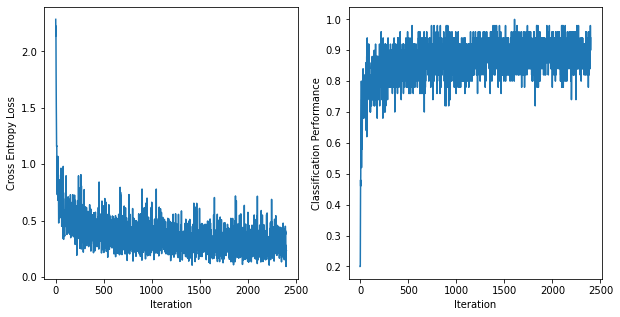

In [6]:
# Training
model_no_pyr = ConvFull([28, 28], order=4, scales=2, kernel_size=6, output_dim=60)
loader = torch.utils.data.DataLoader(train_set, batch_size = 50)
optimizer = torch.optim.Adam(model_no_pyr.parameters(), lr=1e-3)


epoch = 2
losses = []
fracts_correct = []
for e in range(epoch):
    for batch in loader:
        images = batch[0]
        labels = batch[1]
        preds = model_no_pyr(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        n_correct = preds.argmax(dim=1).eq(labels).sum().item()
        fracts_correct.append(n_correct / 50)
        
fig, axs = plt.subplots(1, 2, figsize=(10, 5))     
axs[0].plot(losses)
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Cross Entropy Loss')
axs[1].plot(fracts_correct)
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Classification Performance')

Text(0.5, 1.0, 'Filters Learned Directly From Data')

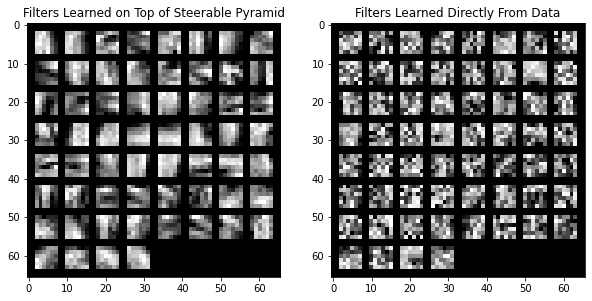

In [7]:
# Feature Visualization
conv_weights = model_pyr.conv.weight.detach().view(-1, 1, 6, 6)
conv_weights = make_grid(conv_weights, normalize=True, scale_each=True)
conv_weights = conv_weights.numpy()
conv_weights_pyr = np.transpose(conv_weights, (1, 2, 0))

conv_weights = model_no_pyr.conv.weight.detach().view(-1, 1, 6, 6)
conv_weights = make_grid(conv_weights, normalize=True, scale_each=True)
conv_weights = conv_weights.numpy()
conv_weights_no_pyr = np.transpose(conv_weights, (1, 2, 0))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(conv_weights_pyr, cmap='gray')
axs[0].set_title('Filters Learned on Top of Steerable Pyramid')
axs[1].imshow(conv_weights_no_pyr, cmap='gray')
axs[1].set_title('Filters Learned Directly From Data')

NOTE: These are not directly comparable. The convolutional filters learned on top of the pyramid operate on several (in this case 20) input channels, while those learned on the data operate on a single input channels. Therefore the first 20 kernels shown in the left plot are really *channel wise slices of the same filter*, while each kernel displayed on the right plot is entirely distinct.

## Probing the effect of the Steerable Pyramid using Eigendistortions

Eigendistortions provide a way to determine the perturbations a given model is most or least sensitive to. For an introduction to Eigendistortions see here https://github.com/LabForComputationalVision/plenoptic/blob/master/examples/02_Eigendistortions.ipynb or here https://github.com/LabForComputationalVision/plenoptic/blob/master/examples/Demo_Eigendistortion.ipynb. 

Though both models above were trained to relatively similar cross entropy loss and classification performatnc, one might expect the pyramid model to be sensitive to changes in a more "human-like," way, as the design of the steerable pyramid is roughly inspired by the early primate visual system.

In [8]:
# a sample image
fmnist_im = images[4, :, :]
fmnist_im = fmnist_im.unsqueeze(0)

# initialize distortion synthesizers
eigendist_pyr = Eigendistortion(base_signal=fmnist_im, model=model_pyr)
eigendist_no_pyr = Eigendistortion(base_signal=fmnist_im, model=model_no_pyr)

# synthesize distortions
distortions_pyr, eigenvals_pyr, eigenind_pyr = eigendist_pyr.synthesize(k=3, method='power', max_steps=2000)
distortions_no_pyr, eigenvals_no_pyr, eigenind_no_pyr = eigendist_no_pyr.synthesize(k=3, method='power', max_steps=2000)


Initializing Eigendistortion -- Input dim: 784 | Output dim: 10

Initializing Eigendistortion -- Input dim: 784 | Output dim: 10


Top k=3 eigendists:   0%|          | 0/2000 [00:00<?, ?it/s]

Top k=3 eigendists computed | Tolerance 1.00E-07 reached.


Bottom k=3 eigendists:   0%|          | 0/2000 [00:00<?, ?it/s]

Bottom k=3 eigendists computed | Tolerance 1.00E-07 reached.


Top k=3 eigendists:   0%|          | 0/2000 [00:00<?, ?it/s]

Top k=3 eigendists computed | Tolerance 1.00E-07 reached.


Bottom k=3 eigendists:   0%|          | 0/2000 [00:00<?, ?it/s]

Bottom k=3 eigendists computed | Tolerance 1.00E-07 reached.


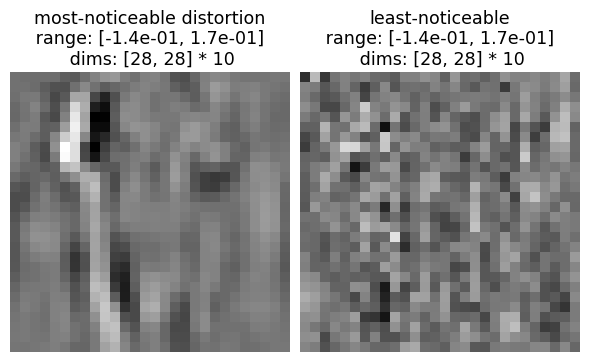

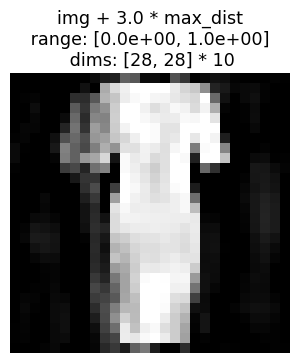

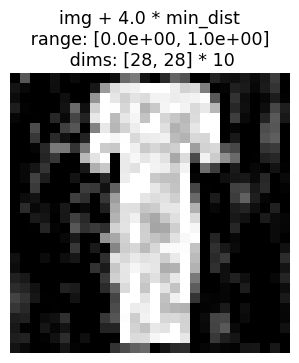

In [9]:
po.imshow(distortions_pyr[[0,-1]].mean(1, keepdim=True), vrange='auto1',
          title=["most-noticeable distortion", "least-noticeable"], zoom=10)

alpha_max, alpha_min = 3., 4.

f_max = eigendist_pyr.plot_distorted_image(eigen_index=0, alpha=alpha_max, title=f'img + {alpha_max} * max_dist',
                                           zoom=10)
f_min = eigendist_pyr.plot_distorted_image(eigen_index=-1, alpha=alpha_min, title=f'img + {alpha_min} * min_dist',
                                           zoom=10)

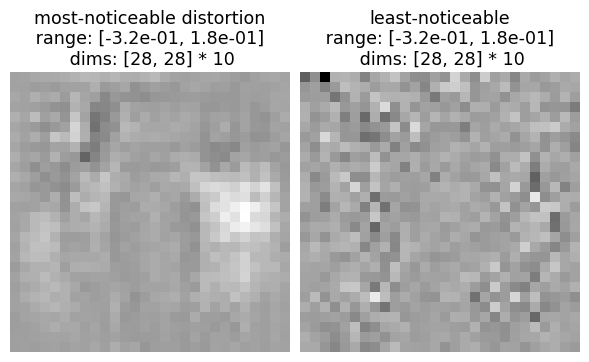

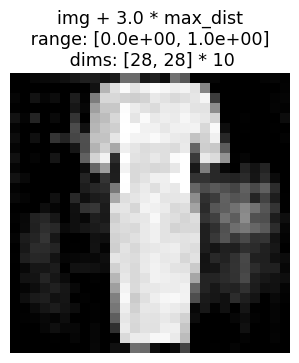

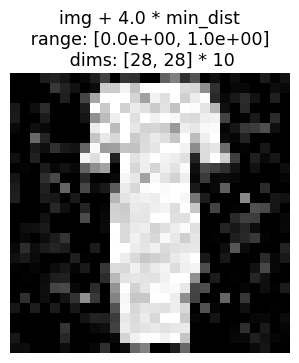

In [10]:

po.imshow(distortions_no_pyr[[0,-1]].mean(1, keepdim=True), vrange='auto1',
          title=["most-noticeable distortion", "least-noticeable"], zoom=10)

alpha_max, alpha_min = 3., 4.
f_max = eigendist_no_pyr.plot_distorted_image(eigen_index=0, alpha=alpha_max, title=f'img + {alpha_max} * max_dist',
                                              zoom=10)
f_min = eigendist_no_pyr.plot_distorted_image(eigen_index=-1, alpha=alpha_min, title=f'img + {alpha_min} * min_dist', 
                                              zoom=10)

Without a psychophysical experiment there's no way to declare one model is more or less human-like in terms of the perturbations it is most/least sensitive too, but you are free to draw your own conclusions! 